#This notebook classifies localization of a protein from the Yeast dataset

In [1]:
#IMPORT LIBRARIES

In [2]:
import pandas as pd; import numpy as np

In [3]:
#LOAD DATA

In [4]:
master = pd.read_csv('yeast.csv') #dataset with 8 variables, localization is in feature 'Target'

backup = master

In [5]:
master.head()      #sanity check

,Sequence Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,Target
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [6]:
#START RE-RUNNING CODE FROM HERE

master = backup
master.shape

(1484, 10)

In [7]:
#Look at the different classes in the dataset: ERL has only 5 samples

master['Target'].value_counts()

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: Target, dtype: int64

In [8]:
#drop ERL due to insufficient data

# master = master[master['Target'] != 'ERL']
master.shape

(1484, 10)

In [9]:
#drop sequence name column, do not need this column

master = master.drop(columns='Sequence Name')
master.shape

(1484, 9)

In [10]:
#identify feature columns

data = master.columns.drop('Target')

In [11]:
#label encode the target localization site

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
localization = ['CYT', 'ERL', 'EXC', 'ME1', 'ME2', 'ME3', 'MIT', 'NUC', 'POX', 'VAC']
le.fit(localization)
target = le.fit_transform(master['Target'])

In [12]:
#onehotencode the target localization site

from keras.utils import np_utils

target = np_utils.to_categorical(target)

/home/abhay/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
#join the indicator variables to create master dataframe with features as well as OneHotEncoded target

master = master.join(pd.DataFrame(data=target, columns=localization))
master.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,Target,CYT,ERL,EXC,ME1,ME2,ME3,MIT,NUC,POX,VAC
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
#LOF outlier detection (this is what we chose to use)

from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination='auto')

lofOutliers = lof.fit_predict(master[data])

In [15]:
#identify number of samples with highest outlier score

(lofOutliers == -1).sum()

76

In [16]:
#Isolation Forest outlier detection 

from sklearn.ensemble import IsolationForest

iso = IsolationForest(behaviour='new', max_features=8, contamination='auto')

iso.fit(master[data])
isoOutliers = iso.predict(master[data])

In [17]:
#identify samples with highest outlier score

(isoOutliers == -1).sum()


66

In [18]:
# compare the common outliers from both functions

((isoOutliers - lofOutliers) == 2).sum()

32

In [19]:
#DROP OUTLIER SAMPLES

master = master[lofOutliers == 1]
master.shape

(1408, 19)

In [20]:
# split into train and test

from sklearn.model_selection import train_test_split

trainData, testData, trainTarget, testTarget = train_test_split(master[data], master[localization], 
                                                                test_size = 0.3, random_state = 0)


In [21]:
trainTarget.head()        #sanity check

,CYT,ERL,EXC,ME1,ME2,ME3,MIT,NUC,POX,VAC
691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
85,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
970,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1053,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#select only CYT samples from train and test sets

trainCYT = trainData[trainTarget['CYT'] == 1]
testCYT = testData[testTarget['CYT'] == 1]
trainCYT.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
970,0.61,0.48,0.56,0.19,0.5,0.0,0.53,0.31
456,0.50,0.46,0.52,0.16,0.5,0.0,0.52,0.26
1053,0.38,0.40,0.53,0.12,0.5,0.0,0.55,0.22
366,0.64,0.53,0.45,0.13,0.5,0.0,0.53,0.22
999,0.73,0.60,0.47,0.20,0.5,0.0,0.72,0.22


In [23]:
#   4-STEP MODELLING PROCESS: IMPORT MODEL, ADD LAYERS TO MODEL, TRAIN USING FIT, EVALUATE

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy

In [25]:
#using stochastic gradient descent, set learning rate

sgd = SGD(lr = 0.01)

In [26]:
model = Sequential()
model.add(Dense(3, input_shape=(8,), activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [27]:
#plot details for CYT class

import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint as mc
from keras.callbacks import LambdaCallback as lc

weightList = [[],[],[],[]]
cyt_err_train = []
cyt_err_test = []

node1 = lc(on_epoch_end=lambda epoch, logs: weightList[0].append(model.layers[2].get_weights()[0][0][0]))
node2 = lc(on_epoch_end=lambda epoch, logs: weightList[1].append(model.layers[2].get_weights()[0][1][0]))
node3 = lc(on_epoch_end=lambda epoch, logs: weightList[2].append(model.layers[2].get_weights()[0][2][0]))
node4 = lc(on_epoch_end=lambda epoch, logs: weightList[3].append(model.layers[2].get_weights()[1][0]))


In [28]:
weightList = [[],[],[],[]]
numepochs = 100
batch = 1

model.fit(trainData.values, trainTarget.values, epochs = numepochs, 
                    batch_size=batch, callbacks=[node1, node2, node3, node4])

Epoch 1/100
985/985 [==============================] - 4s 4ms/step - loss: 1.8798 - acc: 0.3259
Epoch 2/100
985/985 [==============================] - 3s 3ms/step - loss: 1.7272 - acc: 0.3289
Epoch 3/100
985/985 [==============================] - 2s 3ms/step - loss: 1.7102 - acc: 0.3320
Epoch 4/100
985/985 [==============================] - 3s 3ms/step - loss: 1.7047 - acc: 0.3310
Epoch 5/100
985/985 [==============================] - 3s 3ms/step - loss: 1.7009 - acc: 0.3320
Epoch 6/100
985/985 [==============================] - 3s 3ms/step - loss: 1.6985 - acc: 0.3299
Epoch 7/100
985/985 [==============================] - 3s 3ms/step - loss: 1.6991 - acc: 0.3279
Epoch 8/100
985/985 [==============================] - 3s 3ms/step - loss: 1.6977 - acc: 0.3310
Epoch 9/100
985/985 [==============================] - 3s 3ms/step - loss: 1.6963 - acc: 0.3279
Epoch 10/100
985/985 [==============================] - 3s 3ms/step - loss: 1.6952 - acc: 0.3310
Epoch 11/100
985/985 [=================

985/985 [==============================] - 2s 2ms/step - loss: 1.5344 - acc: 0.3594
Epoch 86/100
985/985 [==============================] - 2s 2ms/step - loss: 1.5250 - acc: 0.3736
Epoch 87/100
985/985 [==============================] - 2s 2ms/step - loss: 1.5147 - acc: 0.3675
Epoch 88/100
985/985 [==============================] - 2s 2ms/step - loss: 1.5056 - acc: 0.3766
Epoch 89/100
985/985 [==============================] - 2s 2ms/step - loss: 1.4981 - acc: 0.3807
Epoch 90/100
985/985 [==============================] - 2s 2ms/step - loss: 1.4886 - acc: 0.3838
Epoch 91/100
985/985 [==============================] - 2s 2ms/step - loss: 1.4809 - acc: 0.3919
Epoch 92/100
985/985 [==============================] - 2s 2ms/step - loss: 1.4736 - acc: 0.3939
Epoch 93/100
985/985 [==============================] - 2s 2ms/step - loss: 1.4689 - acc: 0.3868
Epoch 94/100
985/985 [==============================] - 2s 2ms/step - loss: 1.4623 - acc: 0.3909
Epoch 95/100
985/985 [=====================

In [29]:
#EVALUATE MODEL USING METRICS

model.evaluate(testData.values, testTarget.values, batch_size=batch)

423/423 [==============================] - 0s 984us/step


[1.4144956797854558, 0.425531914893617]

In [30]:
weightList = np.array(weightList).T

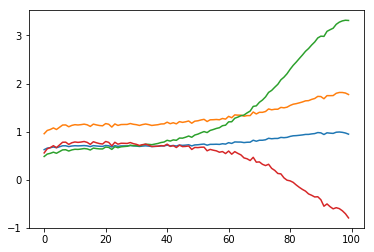

In [31]:
import matplotlib.pyplot as plt

plt.plot(weightList)
plt.show()

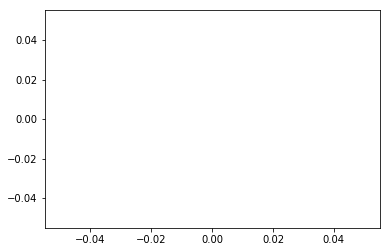

In [32]:
plt.plot(cyt_err_test)
plt.plot(cyt_err_train)
plt.show()

In [ ]:
#Train on all data instead of just the train set

In [ ]:
model3 = Sequential()
model3.add(Dense(3, input_shape=(8,), activation='sigmoid'))
model3.add(Dense(3, activation='sigmoid'))
model3.add(Dense(9, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [ ]:
history = model3.fit(master[data].values, master[localization].values, epochs = numepochs, batch_size=batch)

In [ ]:
#EVALUATE MODEL USING PRECISION METRICS

model.evaluate(master[data].values, master[localization].values, batch_size=batch)

In [ ]:
model3.evaluate(master[data].values, master[localization].values, batch_size=batch)